# Goal

* [Visualize data](#visualize_data_cell)
* [Classification models](#classification_models_cell) 
  * [Logistic regression](#logistic_regression_cell)
  * [Convolutional neural network](#convolutional_neural_network_cell)  
* [Video](#video_cell)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

import os 
import pickle

from PIL import Image
from tabulate import tabulate
import warnings

import pandas as pd
import numpy as np

import random

import time

import io
import base64
from IPython.display import HTML

from sknn.mlp import Classifier, Layer, Convolution
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.learning_curve import learning_curve

## Utility Function

In [3]:
direction_map = {1: "F", 
                 6: "FR",
                 7: "FL"}

def plot_validation_curve(parameter,
                          param_range, 
                          train_mean,
                          train_std,
                          test_mean,
                          test_std):
    """
    parameter: String. The X axis of the plot.
    param_range: Array. X axis points.
    train_mean: Array. Training average over points defined in param_range.
    train_std: Array. Training standard deviation over points defined in param_range.
    test_mean: Array. Test average over points defined in param_range.
    train_std: Array. Training standard deviation over points defined in param_range.
    """
    plt.plot(param_range, train_mean,
             color='blue', marker='o',
             markersize=5,
             label='Training accuracy')
    
    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color='blue')
    
    plt.plot(param_range, 
             test_mean, 
             color='green', 
             linestyle='--',
             marker='s', 
             markersize=5,
             label='Validation accuracy')
    
    plt.fill_between(param_range,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, 
                     color='green')
    
    plt.grid()
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.xlabel('Parameter {0}'.format(parameter), fontdict={'fontsize': 15})   
    plt.ylabel('Accuracy', fontdict={'fontsize': 15})
    plt.ylim([0.6, 1.0])
    plt.title('Validation Curve', fontdict={'fontsize': 20})
    plt.show()

    
def plot_learning_curve(trian_sizes,
                        train_mean,
                        train_std,
                        test_mean,
                        test_std):
    plt.plot(train_sizes, 
             train_mean,
             color='blue', 
             marker='o',
             markersize=5,
             label='Training accuracy')
    
    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, 
                     color='blue')
    
    plt.plot(train_sizes, 
             test_mean,
             color='green', 
             linestyle='--',
             marker='s', 
             markersize=5,
             label='Validation accuracy')
    
    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, 
                     color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6, 1.0])
    plt.show()


def get_data(classifier):
    
    """
    ** Purpose **
    This function returns the images and the directions associated with 
    the images which were recorded while collecting data. 
    
    ** Input **
    classifier: 'cnn' or anything else. If 'cnn', we do not linearize the returned image. 
    
    ** Left-right SYMMETRY **
    The images have left-right symmetry. This function uses this knowledge to 
    synthesize new images. Each new image is a mirror reflection of the collected image, 
    with the corresponding direction appropriately changed {R->L. L->R, F->F}. 
    This has the effect of doubling our sample size. 
    
    ** Image dimensions **
    The images in the data files are stored as (120x160) numpy arrays. 
    When using the images for classification, we strip the top 20 rows of the image
    and then downsize the image. The images which are returned are (25x40) numpy arrays. 
    Later in the code, when we have Image.resize(40, 25). 
    Here, 40 is the width (columns) and 25 is the height (rows) of the image. 
    
    ** Structure of input files **
    The images and the corresponding directions are in the following files:
    '/home/shantanu/PycharmProjects/RCCar/training_images/data'
    '/home/shantanu/PycharmProjects/RCCar/training_images/data1'
    '/home/shantanu/PycharmProjects/RCCar/training_images/data2'
    '/home/shantanu/PycharmProjects/RCCar/training_images/data3'
    ... 
    
    Each file has a dictionary of list of images and the corresponding directions
    For example a file will typically have 
    {"Directions": [d1, d2, d3, ...], "Images": [im1, im2, im3, ...]}
    
    The directions and images are in sequence and can be used for classification by 
    classifiers which are known to perform well for sequential data (not done in this project). 
    """
    
    data_store_path_common = '/home/shantanu/PycharmProjects/RCCar/training_images/data'
    data_store_path = data_store_path_common
    directions = []
    images = []
    data_set_count = 0
    while os.path.isfile(data_store_path):
        images_and_directions = pickle.load(open(data_store_path, "rb"))
        directions += images_and_directions["Directions"]
        images +=  images_and_directions["Images"]
        data_set_count += 1
        data_store_path = data_store_path_common + str(data_set_count)

    def get_flipped_images(im_array, di):
        """
        im_array: List of np.array corresponding to images
        di: List of directions
        Returns [flipped_images, flipped_directions] 
        where
        flipped_images are the LEFT_RIGHT flipped version of images in im_array 
        and
        flipped_directions are the flipped directions
        defined by
        flip_direction_map = {forward -> forward, right_forward -> left_forward, left_forward -> right_forward}
        """
        flip_direction_map = {1: 1, # forward -> forward
                              6: 7, # right_forward -> left_forward
                              7: 6} # left_forward -> right_forward
        flipped_images = [np.array(Image.fromarray(_im).transpose(Image.FLIP_LEFT_RIGHT)) for _im in im_array]
        flipped_directions = [flip_direction_map[_d] for _d in di]
        return [flipped_images, flipped_directions]


    flipped_images, flipped_direcions = get_flipped_images(images, directions)
    images += flipped_images
    directions += flipped_direcions
    
    top_rows_to_discard = 20
    height = 25
    width = 40
    if classifier == 'cnn':
        return [np.array([np.asarray(Image.fromarray(_im[top_rows_to_discard:,:]).resize((width, height), Image.ANTIALIAS)) for _im in images]), 
                np.array([_d for _d in directions])]
    else:
        d = np.array([_direc for _direc in directions])
        i = np.array([])
        ar_shape = (1, width*height)
        for _im in images:
            temp_im = np.asarray(Image.fromarray(_im[top_rows_to_discard:,:]).resize((width, height), Image.ANTIALIAS)).reshape(ar_shape)
            if i.size == 0:
                i = temp_im
            else:
                i = np.append(i, temp_im, axis=0)
        return [i, d]

<a id='visualize_data_cell'></a>

## Visualize data

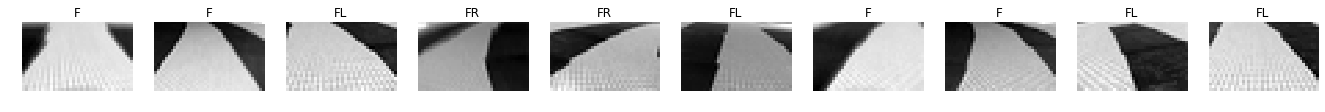

In [4]:
images, directions = get_data('cnn')
num_of_images_to_show = 10
num_of_samples = len(images)
image_idx = random.sample(xrange(num_of_samples), num_of_images_to_show)

for index, (image, direction) in enumerate(zip(images[image_idx], directions[image_idx])):
    pylab.subplot(2, num_of_images_to_show, index + num_of_images_to_show + 1)
    pylab.axis('off')
    pylab.subplots_adjust(left=6.0, right=9.0)
    pylab.imshow(image, cmap=pylab.cm.gray_r, interpolation='nearest')
    pylab.title(direction_map[direction])

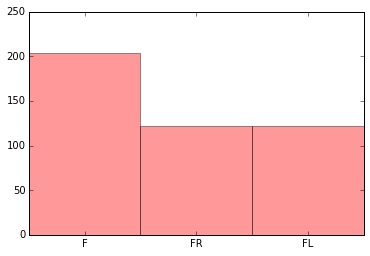

In [5]:
classes = np.unique(directions)
bar_width = 1.0
opacity=0.4
plt.bar(np.arange(len(np.unique(directions))), 
        tuple([np.sum(directions==_d) for _d in classes]), 
        bar_width,
        alpha=opacity,
        color='r')
plt.xticks([0.5, 1.5, 2.5], [direction_map[_d] for _d in classes])
plt.show()

In [6]:
print "Number of samples classified as Forward = {0} ".format(np.sum(directions == 1) * 1./len(directions))
print "Number of samples classified as Right-Forward = {0} ".format(np.sum(directions == 6) * 1./len(directions))
print "Number of samples classified as Left-Forward = {0} ".format(np.sum(directions == 7) * 1./len(directions))

Number of samples classified as Forward = 0.455357142857 
Number of samples classified as Right-Forward = 0.272321428571 
Number of samples classified as Left-Forward = 0.272321428571 


From the above, we see that 'Forward' is the most frequent class appearing in the sample, with $45.5\%$ of all the samples classified as 'Forward'. Any machine learning model which we consider, should aim to improve on this base line accuracy of $45.5\%$

<a id='classification_models_cell'></a>

## Classification models

<a id='logistic_regression_cell'></a>

### Logistic regression

* Library: Here, we use [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for the purpose of classifying the images to their corresponding directions.
* Hyper-parameters: We tune our model on the _inverse_ of the regularization parameter: C. 
* For each grid point, we used [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html), with default 3 folds, to find the average and standard deviation of training scores and validation sores. 
  * Because we are tuning over only one hyper-parameter, we could have used [sklearn.learning_curve.learning_curve](http://scikit-learn.org/stable/modules/learning_curve.html) for this purpose, but we did not because we wanted a generic way which could handle mupliple hyper-parameters (which will be important when we discuss [convolutional neural network model](#convolutional_neural_network_cell)).
* Storage: The training and validation scores for each grid point is pickled as a pandas dataframe. 

In [9]:
"""
Grid search
"""
params = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
cols = ['C', 'avg_training_score', 'std_training_score', 'avg_test_score', 'std_test_score']
lr_df = pd.DataFrame(columns=cols)

X, y = get_data('lr')
for _C in params['C']:
    training_score = []
    test_score = []
    for train, test in StratifiedKFold(y):
        lr = LogisticRegression(C=_C)
        x_tr, x_te = X[train], X[test]
        y_tr, y_te = y[train], y[test]
        lr.fit(x_tr/255., y_tr)
        training_score.append(lr.score(x_tr/255., y_tr))
        test_score.append(lr.score(x_te/255., y_te))
    lr_df = lr_df.append({'C': _C,
                          'avg_training_score': np.average(training_score),
                          'std_training_score': np.std(training_score),
                          'avg_test_score': np.average(test_score),
                          'std_test_score': np.std(test_score)},
                         ignore_index=True)

lr_para_score_path = '/home/shantanu/PycharmProjects/RCCar/lr_para_scores.pkl'
with open(lr_para_score_path, 'wb') as f:
    pickle.dump(lr_df, f)

In [10]:
lr_para_score_path = '/home/shantanu/PycharmProjects/RCCar/lr_para_scores.pkl'
with open(lr_para_score_path, 'rb') as f:
    lr_df= pickle.load(f)
    
#print tabulate(lr_df, headers='keys', tablefmt='fancy_grid')

lr_df = np.round(lr_df, decimals=3)
lr_df.sort(['avg_test_score']).tail(10)

,C,avg_training_score,std_training_score,avg_test_score,std_test_score
0,0.001,0.682,0.040,0.676,0.060
5,100.000,0.996,0.002,0.681,0.037
4,10.000,0.985,0.004,0.712,0.038
1,0.010,0.793,0.038,0.730,0.074
2,0.100,0.851,0.033,0.750,0.070
3,1.000,0.916,0.017,0.752,0.040


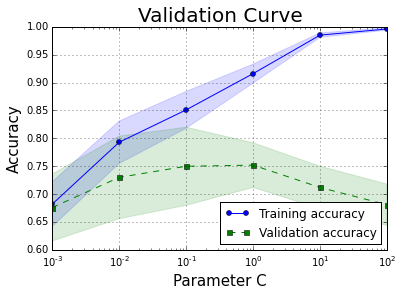

In [13]:
"""
Validation curve
"""
plot_validation_curve('C',
                      lr_df['C'].values,
                      lr_df['avg_training_score'].values,
                      lr_df['std_training_score'].values,
                      lr_df['avg_test_score'].values,
                      lr_df['std_test_score'].values)

From the above validation curve, we see that the best performance of the model takes place for $$C = 1.0$$ for which we get the optimal validation accuracy of $75.1\%$. For higher values of $C$ (that is smaller regularization strength), we see that there is significant overfitting as the training accuracy reaches $99.5\%$ where as the validation accuracy dips to $68.0\%$ for $C=100.0$. 

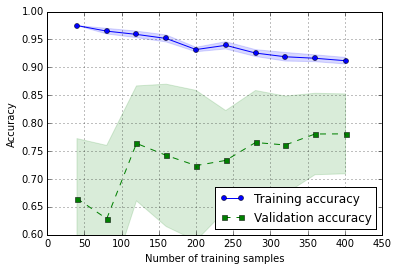

In [14]:
"""
Learning curve
"""
C_best = 1.0
lr_clf_best = LogisticRegression(C=C_best)

X_train, y_train = get_data('lr')
train_sizes, train_scores, test_scores = learning_curve(estimator=lr_clf_best, 
                                                        X=X_train/255.,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10)

plot_learning_curve(train_sizes,
                    np.mean(train_scores, axis=1),
                    np.std(train_scores, axis=1),
                    np.mean(test_scores, axis=1),
                    np.std(test_scores, axis=1))

In order to see if collecting more data can might help in improving the accuracy of the logiestic regression classifier, we plot above the learning curve. We see that the validation accuracy curve is almost flat at the end and so we dont expect the accuracy to improve much further. 

Also, even for the best chosen hyper-parameter, $C$, we see there is a significant gap between the training and test curve, implying over-fitting. 

In [32]:
"""
Pickle cnn_clf_best
"""
C_best = 1.0
lr_clf_best = LogisticRegression(C=C_best)

X, y = get_data('lr')
lr_clf_best.fit(X/255., y)

lr_classifier_path = '/home/shantanu/PycharmProjects/RCCar/lr_classifier.pkl'
with open(lr_classifier_path, 'wb') as f:
    pickle.dump(lr_clf_best, f)

### Logestic regression summary

The best validation accuracy for logestic regression is found to be $75.1\%$. This is an improvement over the base case of $45.5\%$. 

From the learning curve, we see that increasing the number of training samples in unlikely to improve the accuracy of the model.

<a id='convolutional_neural_network_cell'></a>

## Convolutional neural network
* Library: We use [sknn.mlp.Classifier](http://scikit-neuralnetwork.readthedocs.io/en/latest/module_mlp.html#classifier) with a convolutional layer for the purpose of classifying the images to their corresponding directions. 
  * Using pool_size in Convolution layer caused an error: TypeError: max_pool_2d() got an unexpected keyword argument 'mode'.  
* Hyper-parameters: The hyper-parameters which we tuned over is given in the dictionary: "params". For each grid point, we used [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html), with default 3 folds, to find the average and standard deviation of training scores and validation sores. The reason we used StratifiedKFold is because the sample data for which the images are classified as "Forward" are almost double as compared to the number of images classified to go "Right-Forward" or "Left-Forward".
  * Instead of using "for loop" for performing grid search over the parameter space, we could have used [GridSearchCV](http://scikit-neuralnetwork.readthedocs.io/en/latest/guide_sklearn.html#grid-search). The reason we did not do this is because GridSearchCV does not return the statistics of training scores, and only returns the statistics of validation scores (I might be wrong in this but this is what my current understanding is.).   
* Storage: The training and validation scores for each grid point is pickled as a pandas dataframe. 
* Run time: It took approximately 1750 minutes of wall clock time on a personal laptop (without GPU).

In [21]:
# To run 
#  run_grid_search_for_cnn = True
#  store_grid_score_cnn = True
# WARNING: This cell takes around 2000 minutes to run!!!

warnings.filterwarnings('ignore')
params = {'weight_decay': [0.001, 0.1, 1.0, 10.0, 100],
          'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
          'dropout_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
          'units': [50, 100, 150, 200, 250]}

cols = ['weight_decay', 'learning_rate', 'dropout_rate', 'units',
        'avg_training_score', 'std_training_score', 'avg_test_score', 'std_test_score']
cnn_df = pd.DataFrame(columns=cols)

X, y = get_data('cnn')
count = 0
t0 = time.clock()
 
run_grid_search_for_cnn = False

if run_grid_search_for_cnn:
    for _w in params['weight_decay']:
        for _l in params['learning_rate']:
            for _d in params['dropout_rate']:
                for _u in params['units']:
                    training_score = []
                    test_score = []
                    for train, test in StratifiedKFold(y):
                        nn = Classifier(
                            layers=[
                                Convolution('Rectifier', channels=8, kernel_shape=(15, 15)),
                                Layer('Rectifier', units=_u),
                                Layer('Softmax')],
                            n_stable=10,
                            regularize='L2',
                            dropout_rate=_d,
                            weight_decay=_w,
                            learning_rate=_l,
                            #callback={'on_epoch_finish': on_epoch_finish},
                            n_iter=100,
                            batch_size=10)
                        x_tr, x_te = X[train], X[test]
                        y_tr, y_te = y[train], y[test]
                        nn.fit(x_tr/255., y_tr)
                        training_score.append(nn.score(x_tr/255., y_tr))
                        test_score.append(nn.score(x_te/255., y_te))
                        count += 1
                        print count
                    cnn_df = cnn_df.append({'weight_decay': _w,
                                            'learning_rate': _l,
                                            'dropout_rate': _d,
                                            'units': _u,
                                            'avg_training_score': np.average(training_score),
                                            'std_training_score': np.std(training_score),
                                            'avg_test_score': np.average(test_score),
                                            'std_test_score': np.std(test_score)},
                                           ignore_index=True)
                    print (time.clock() - t0) / 60.0

store_grid_score_cnn = False
if store_grid_score_cnn:
    cnn_para_score_path = '/home/shantanu/PycharmProjects/RCCar/cnn_para_scores.pkl'
    with open(cnn_para_score_path, 'wb') as f:

        pickle.dump(cnn_df, f)

In [17]:
cnn_para_score_path = '/home/shantanu/PycharmProjects/RCCar/cnn_para_scores.pkl'
with open(cnn_para_score_path, 'rb') as f:
    cnn_df= pickle.load(f)

cnn_df = np.round(cnn_df, decimals=3)
cnn_df.sort(['avg_test_score']).tail(10)

,weight_decay,learning_rate,dropout_rate,units,avg_training_score,std_training_score,avg_test_score,std_test_score
426,10.000,0.010,0.05,100,0.879,0.017,0.835,0.034
30,0.001,0.005,0.10,50,0.849,0.012,0.837,0.012
179,0.100,0.010,0.05,250,0.885,0.023,0.837,0.017
277,1.000,0.005,0.05,150,0.866,0.012,0.837,0.017
570,100.000,0.010,0.25,50,0.857,0.015,0.837,0.019
187,0.100,0.010,0.15,150,0.862,0.013,0.839,0.028
403,10.000,0.005,0.05,200,0.882,0.013,0.839,0.012
416,10.000,0.005,0.20,100,0.858,0.005,0.839,0.010
438,10.000,0.010,0.15,200,0.873,0.007,0.839,0.012
189,0.100,0.010,0.15,250,0.873,0.019,0.842,0.013


From the above table, we see that for convolutional neural network, we get best test score of $84.2\%$. The optimal parameters corresponding to the best score are: $$$$ $$weight\_decay = 0.10$$ $$learning\_rate =  0.01$$ $$dropout\_rate = 0.15$$ $$units = 250$$

In [ ]:
"""
Learning curve
WARNING: It takes around 60 minutes to run this cell. 
"""

weight_decay_best = 0.1
learning_rate_best = 0.01
dropout_rate_best = 0.15
units_best = 250

cnn_clf_best = Classifier(layers=[Convolution('Rectifier', channels=8, kernel_shape=(15, 15)),
                                  Layer('Rectifier', units=units_best),
                                  Layer('Softmax')],
                          n_stable=10,
                          regularize='L2',
                          dropout_rate=dropout_rate_best,
                          weight_decay=weight_decay_best,
                          learning_rate=learning_rate_best,
                          #callback={'on_epoch_finish': on_epoch_finish},
                          n_iter=100,
                          batch_size=10)


X_train, y_train = get_data('cnn')
train_sizes, train_scores, test_scores = learning_curve(estimator=cnn_clf_best, 
                                                        X=X_train/255.,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10)
    
cnn_learning_curve = {'train_sizes': train_sizes,
                     'train_scores': train_scores,
                     'test_scores': test_scores}

cnn_learning_curve_path = '/home/shantanu/PycharmProjects/RCCar/cnn_learning_curve.pkl'
with open(cnn_learning_curve_path, 'wb') as f:
    pickle.dump(cnn_learning_curve, f)

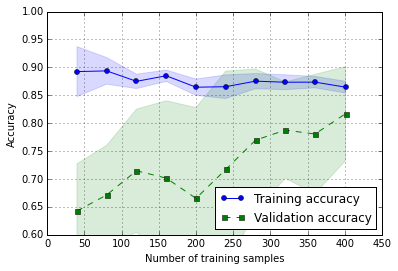

In [23]:
"""
Learning curve
"""
cnn_learning_curve_path = '/home/shantanu/PycharmProjects/RCCar/cnn_learning_curve.pkl'
with open(cnn_learning_curve_path, 'rb') as f:
    cnn_learning_curve = pickle.load(f)
        
plot_learning_curve(cnn_learning_curve['train_sizes'],
                    np.mean(cnn_learning_curve['train_scores'], axis=1),
                    np.std(cnn_learning_curve['train_scores'], axis=1),
                    np.mean(cnn_learning_curve['test_scores'], axis=1),
                    np.std(cnn_learning_curve['test_scores'], axis=1))

In order to see if collecting more data can might help in improving the accuracy of the convolutional neural network classifier, we plot above the learning curve. We see that the validation accuracy curve is an increasing function of the training samples at the end. So we expect the accuracy to improve further if we collect more sample data. 
Also, we see there is a gap between the training and test curve, implying over-fitting. 

In [31]:
"""
Pickle cnn_clf_best
"""

weight_decay_best = 0.1
learning_rate_best = 0.01
dropout_rate_best = 0.15
units_best = 250

cnn_clf_best = Classifier(layers=[Convolution('Rectifier', channels=8, kernel_shape=(15, 15)),
                                  Layer('Rectifier', units=units_best),
                                  Layer('Softmax')],
                          n_stable=10,
                          regularize='L2',
                          dropout_rate=dropout_rate_best,
                          weight_decay=weight_decay_best,
                          learning_rate=learning_rate_best,
                          #callback={'on_epoch_finish': on_epoch_finish},
                          n_iter=100,
                          batch_size=10)

X, y = get_data('cnn')
cnn_clf_best.fit(X/255., y)

cnn_classifier_path = '/home/shantanu/PycharmProjects/RCCar/cnn_classifier.pkl'
with open(cnn_classifier_path, 'wb') as f:
    pickle.dump(cnn_clf_best, f)

### Convolutional neural network summary

The best validation accuracy for convolutional neural network is found to be $84.2\%$. This is a marked improvement over the base case of $45.5\%$ and also a substantial improvement over the $75.1\%$ acuracy reached by logestic regression. From the plot of the learning curve, we see that increasing the number of training samples in likely to improve the accuracy of the model. 